## Video Multi-Object Tracking using MMTracking specific pipeline component

This sample shows how to use `mmtracking_video_multi_object_tracking_pipeline` component from the `azmlft-dev-registry01` dev registry to fine tune a model for image object-detection task using fridgeObjects Dataset. We then deploy the fine tuned model to an online endpoint for real time inference.

### Training data
We will use the [MOT17 tiny](https://download.openmmlab.com/mmtracking/data/MOT17_tiny.zip) dataset.

### Model
We will use the `bytetrack-yolox-x-crowdhuman-mot17-private-half` model in this notebook. If you need to fine tune a model that is available on MmTracking model zoo, but not available in `azmlft-dev-registry01` system registry, you can either register the model and use the registered model or use the `model_name` parameter to instruct the components to pull the model directly from MMTracking model zoo.

### Outline
1. Install dependencies
2. Setup pre-requisites such as compute
3. Pick a model to fine tune
4. Prepare dataset for finetuning the model
5. Submit the fine tuning job using MMDetection specific image object-detection and instance-segmentation component
6. Review training and evaluation metrics
7. Register the fine tuned model
8. Deploy the fine tuned model for real time inference
9. Test deployed end point
9. Clean up resources

### 1. Install dependencies
Before starting off, if you are running the notebook on Azure Machine Learning Studio or running first time locally, you will need the following packages

In [ ]:
! pip install azure-ai-ml==1.8.0
! pip install azure-identity==1.13.0

### 2. Setup pre-requisites

#### 2.1 Connect to Azure Machine Learning workspace

Before we dive in the code, you'll need to connect to your workspace. The workspace is the top-level resource for Azure Machine Learning, providing a centralized place to work with all the artifacts you create when you use Azure Machine Learning.

We are using `DefaultAzureCredential` to get access to workspace. `DefaultAzureCredential` should be capable of handling most scenarios. If you want to learn more about other available credentials, go to [set up authentication doc](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-setup-authentication?tabs=sdk), [azure-identity reference doc](https://learn.microsoft.com/en-us/python/api/azure-identity/azure.identity?view=azure-python).

Replace `<AML_WORKSPACE_NAME>`, `<RESOURCE_GROUP>` and `<SUBSCRIPTION_ID>` with their respective values in the below cell.

In [5]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential


experiment_name = (
    "AzureML-Train-Finetune-Vision-MOT-Samples"  # can rename to any valid name
)

credential = DefaultAzureCredential()
workspace_ml_client = None
try:
    workspace_ml_client = MLClient.from_config(credential)
    subscription_id = workspace_ml_client.subscription_id
    resource_group = workspace_ml_client.resource_group_name
    workspace_name = workspace_ml_client.workspace_name
except Exception as ex:
    print(ex)
    # Enter details of your AML workspace
    subscription_id = "<SUBSCRIPTION_ID>"
    resource_group = "<RESOURCE_GROUP>"
    workspace_name = "<AML_WORKSPACE_NAME>"

workspace_ml_client = MLClient(
    credential, subscription_id, resource_group, workspace_name
)
registry_ml_client = MLClient(
    credential,
    subscription_id,
    resource_group,
    registry_name="azmlft-dev-registry01",
)

Found the config file in: C:\Users\yiyoulin\Projects\azureml-examples\config.json


#### 2.2 Create compute

In order to finetune a model on Azure Machine Learning studio, you will need to create a compute resource first. **Creating a compute will take 3-4 minutes.** 

For additional references, see [Azure Machine Learning in a Day](https://github.com/Azure/azureml-examples/blob/main/tutorials/azureml-in-a-day/azureml-in-a-day.ipynb). 

##### Create CPU compute for model selection component

In [2]:
from azure.ai.ml.entities import AmlCompute
from azure.core.exceptions import ResourceNotFoundError

model_import_cluster_name = "sample-model-import-cluster"
try:
    _ = workspace_ml_client.compute.get(model_import_cluster_name)
    print("Found existing compute target.")
except ResourceNotFoundError:
    print("Creating a new compute target...")
    compute_config = AmlCompute(
        name=model_import_cluster_name,
        type="amlcompute",
        size="Standard_D12_v2",
        idle_time_before_scale_down=120,
        min_instances=0,
        max_instances=4,
    )
    workspace_ml_client.begin_create_or_update(compute_config).result()

Creating a new compute target...


##### Create GPU compute for finetune component

The list of GPU machines can be found [here](https://learn.microsoft.com/en-us/azure/virtual-machines/sizes-gpu).

In [3]:
finetune_cluster_name = "sample-finetune-cluster-gpu"

try:
    _ = workspace_ml_client.compute.get(finetune_cluster_name)
    print("Found existing compute target.")
except ResourceNotFoundError:
    print("Creating a new compute target...")
    compute_config = AmlCompute(
        name=finetune_cluster_name,
        type="amlcompute",
        size="STANDARD_NC6s_v3",
        idle_time_before_scale_down=120,
        min_instances=0,
        max_instances=4,
    )
    workspace_ml_client.begin_create_or_update(compute_config).result()

Creating a new compute target...


### 3. Pick a foundation model to fine tune

We will use the `bytetrack-yolox-x-crowdhuman-mot17-private-half` model in this notebook. If you need to fine tune a model that is available on MMTracking model zoo, but not available in `azmlft-dev-registry01` dev registry, you can either register the model and use the registered model or use the `model_name` parameter to instruct the components to pull the model directly from MMTracking model zoo.

Currently following models are supported:

| Model Name | Source |
| :------------: | :-------:  |
| [bytetrack-yolox-x-crowdhuman-mot17-private-half](https://ml.azure.com/registries/azmlft-dev-registry01/models/bytetrack-yolox-x-crowdhuman-mot17-private-half/version/8) | azureml registry |
| [ocsort-yolox-x-crowdhuman-mot17-private-half](https://ml.azure.com/registries/azmlft-dev-registry01/models/ocsort-yolox-x-crowdhuman-mot17-private-half/version/1) | azureml dev registry |
| [Variants of bytetrack models from MMTracking](https://github.com/open-mmlab/mmtracking/tree/master/configs/mot/bytetrack) | MMTracking |

In [6]:
aml_registry_model_name = "bytetrack-yolox-x-crowdhuman-mot17-private-half"
foundation_model = registry_ml_client.models.get(name=aml_registry_model_name, label="latest")

print(
    f"\n\nUsing model name: {foundation_model.name}, version: {foundation_model.version}, id: {foundation_model.id} for inferencing"
)



Using model name: bytetrack-yolox-x-crowdhuman-mot17-private-half, version: 8, id: azureml://registries/azmlft-dev-registry01/models/bytetrack-yolox-x-crowdhuman-mot17-private-half/versions/8 for inferencing


### 4. Prepare the dataset for fine-tuning the model

We will use the  [MOT17 tiny](https://download.openmmlab.com/mmtracking/data/MOT17_tiny.zip) dataset, a subset of the [MOT17 Challenge](https://motchallenge.net/data/MOT17/). It consists of two video sequences of class {`pedestrian`}.


#### 4.1 Download the Data
We first download and unzip the data locally. By default, the data would be downloaded in `./data` folder in current directory. 
If you prefer to download the data at a different location, update it in `dataset_parent_dir = ...` in the following cell.

In [7]:
import os
import urllib
from zipfile import ZipFile

# Change to a different location if you prefer
dataset_parent_dir = "data"

# create data folder if it doesnt exist.
os.makedirs(dataset_parent_dir, exist_ok=True)

# download data
download_url = "https://download.openmmlab.com/mmtracking/data/MOT17_tiny.zip"

# Extract current dataset name from dataset url
dataset_name = os.path.split(download_url)[-1].split(".")[0]
# Get dataset path for later use
dataset_dir = os.path.join(dataset_parent_dir, dataset_name)

# Get the data zip file path
data_file = os.path.join(dataset_parent_dir, f"{dataset_name}.zip")

# Download the dataset
urllib.request.urlretrieve(download_url, filename=data_file)

# extract files
with ZipFile(data_file, "r") as zzip:
    print("extracting files...")
    zzip.extractall(path=dataset_parent_dir)
    print("done")
# delete zip file
os.remove(data_file)

extracting files...
done


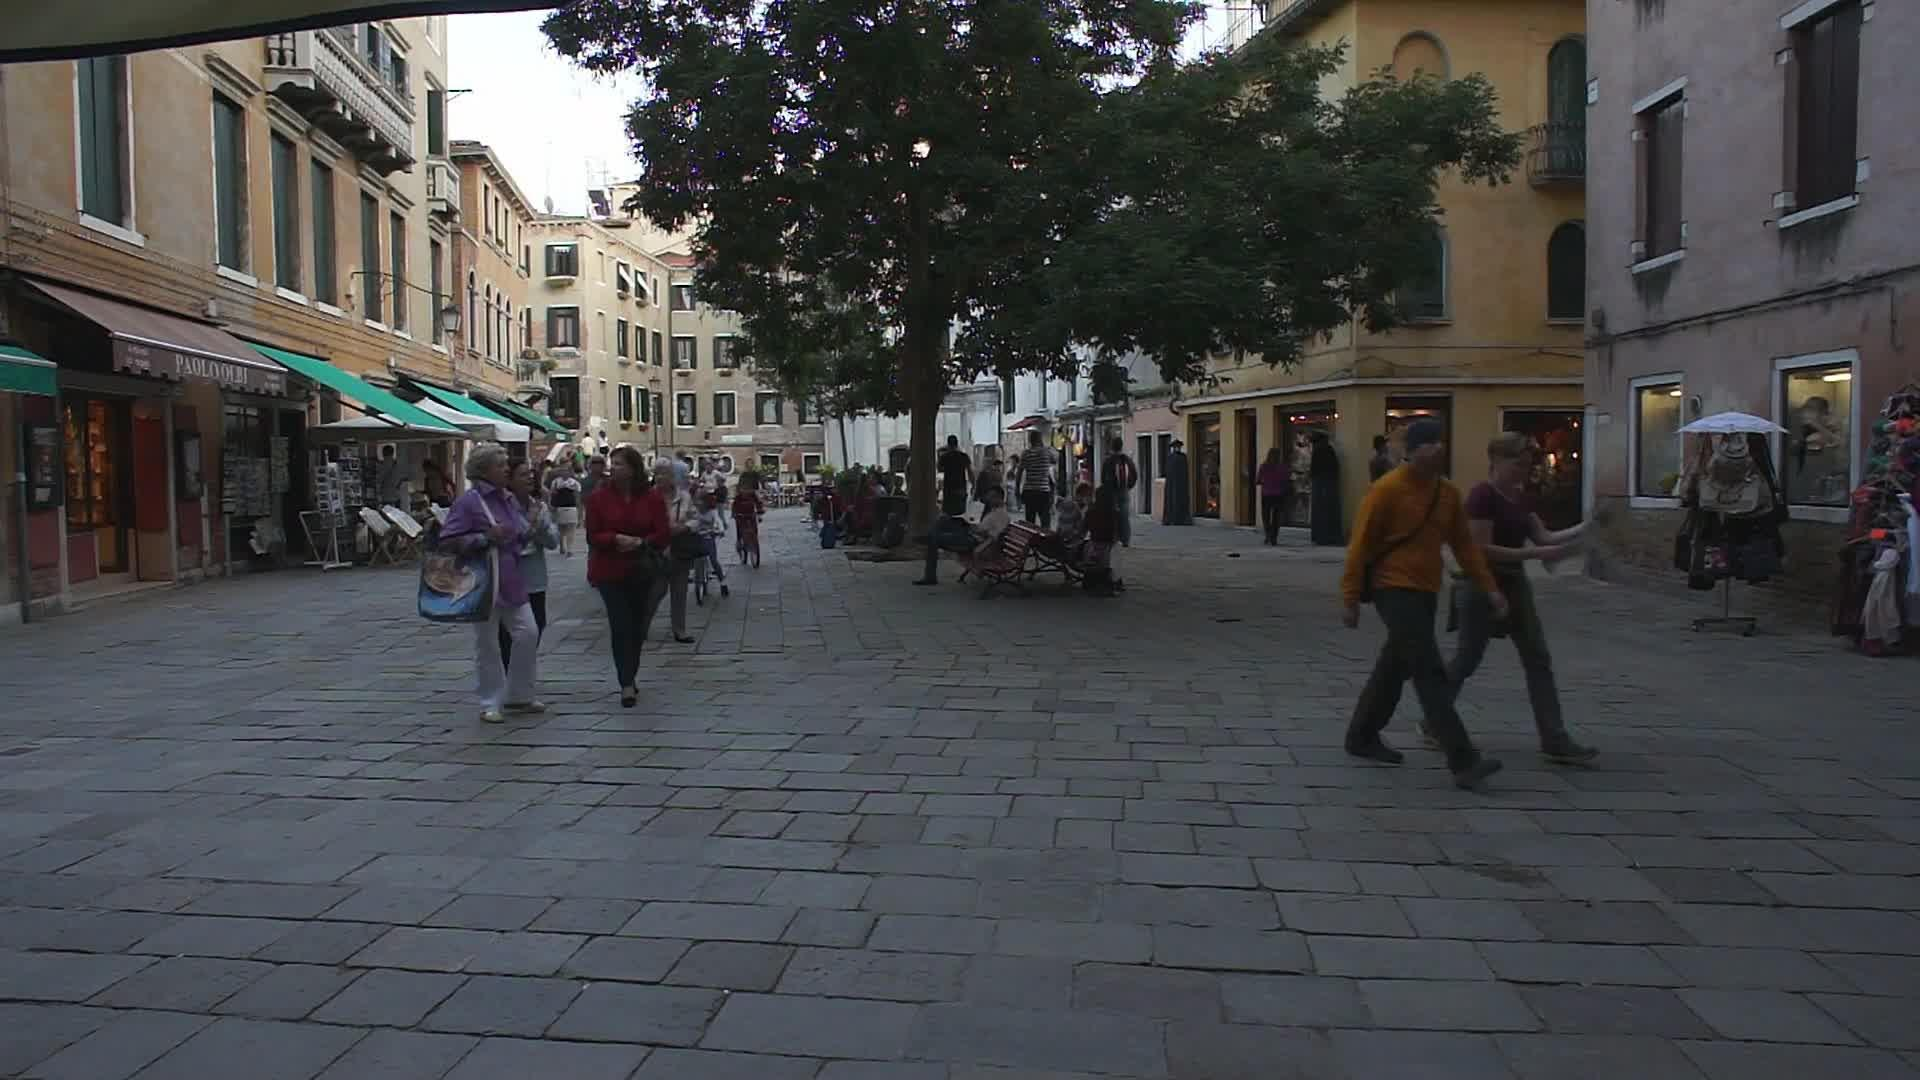

In [8]:
from IPython.display import Image

sample_image = os.path.join(dataset_dir, "train/MOT17-02-FRCNN/img1/000001.jpg")
Image(filename=sample_image)

#### 4.2 Upload the images to Datastore through an AML Data asset (URI Folder)

In order to use the data for training in Azure ML, we upload it to our default Azure Blob Storage of our  Azure ML Workspace.

In [13]:
# Uploading image files by creating a 'data asset URI FOLDER':

from azure.ai.ml.entities import Data
from azure.ai.ml import Input
from azure.ai.ml.constants import AssetTypes

my_data = Data(
    path=dataset_dir,
    type=AssetTypes.URI_FOLDER,
    description=f"{dataset_name} dataset folder",
    name=f"{dataset_name}_sample_folder",
)

uri_folder_data_asset = workspace_ml_client.data.create_or_update(my_data)

# or if the uri_folder was uploaded, we could get it with:
# uri_folder_data_asset = ml_client.data.get(name = f"{dataset_name}_sample_folder", version=1)

print(uri_folder_data_asset)
print("")
print("Path to folder in Blob Storage:")
print(uri_folder_data_asset.path)

Your file exceeds 100 MB. If you experience low speeds, latency, or broken connections, we recommend using the AzCopyv10 tool for this file transfer.

Example: azcopy copy 'C:\Users\yiyoulin\Projects\azureml-examples\sdk\python\foundation-models\system\finetune\video-multi-object-tracking\data\MOT17_tiny' 'https://yiyoulinstoragee9e8f49c7.blob.core.windows.net/azureml-blobstore-dd3851f6-d346-4ba2-a1c9-2fa01208265b/LocalUpload/2eb278bbe1b94bd5900760603b88d9ef/MOT17_tiny' 

See https://docs.microsoft.com/azure/storage/common/storage-use-azcopy-v10 for more information.
Uploading MOT17_tiny (393.41 MBs): 100%|##########| 393411453/393411453 [09:59<00:00, 656435.50it/s]  




creation_context:
  created_at: '2023-10-03T00:37:37.084392+00:00'
  created_by: Yiyou Lin
  created_by_type: User
  last_modified_at: '2023-10-03T00:37:37.100377+00:00'
description: MOT17_tiny dataset folder
id: /subscriptions/dbd697c3-ef40-488f-83e6-5ad4dfb78f9b/resourceGroups/yiyoulin_master/providers/Microsoft.MachineLearningServices/workspaces/yiyoulin_master/data/MOT17_tiny_sample_folder/versions/2
name: MOT17_tiny_sample_folder
path: azureml://subscriptions/dbd697c3-ef40-488f-83e6-5ad4dfb78f9b/resourcegroups/yiyoulin_master/workspaces/yiyoulin_master/datastores/workspaceblobstore/paths/LocalUpload/2eb278bbe1b94bd5900760603b88d9ef/MOT17_tiny/
properties: {}
tags: {}
type: uri_folder
version: '2'


Path to folder in Blob Storage:
azureml://subscriptions/dbd697c3-ef40-488f-83e6-5ad4dfb78f9b/resourcegroups/yiyoulin_master/workspaces/yiyoulin_master/datastores/workspaceblobstore/paths/LocalUpload/2eb278bbe1b94bd5900760603b88d9ef/MOT17_tiny/


#### 4.3 Convert the downloaded data to JSONL

In this example, the MOT17_tiny dataset is stored in a directory. There are two different folders inside `train` image folder, each denoting a different video:

- train/MOT17-02-FRCNN
- train/MOT17-04-FRCNN

This is the most common data format for image object tracking. Inside each of video folder, frames are sorted in sequence.

For documentation on preparing the datasets beyond this notebook, please refer to the [documentation on how to prepare datasets](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-prepare-datasets-for-automl-images).

The following code block converts original dataset to [CocoVid format](https://github.com/open-mmlab/mmtracking/blob/master/tests/data/demo_cocovid_data/ann.json). AzureML pipelines accepts dataset in MLTable format. We will convert MOT17_tiny dataset to Coco-Vid format and then convert Coco-Vid format to MLTable. Most of the datasets are available in Coco-Vid format. In order to demonstrate conversion of Coco-Vid format to MLtable, we do this interim conversion.

In [14]:
# !pip install numpy
!python ./mot2coco.py -i {dataset_dir} -o {dataset_dir}/annotations --split-train --convert-det

Converting train set to COCO format
train has 145 instances.
Done! Saved as data\MOT17_tiny/annotations\train_cocoformat.json and data\MOT17_tiny/annotations\train_detections.pkl
Converting test set to COCO format
test has 0 instances.
Done! Saved as data\MOT17_tiny/annotations\test_cocoformat.json and data\MOT17_tiny/annotations\test_detections.pkl
Converting half-train set to COCO format
half-train has 104 instances.
Done! Saved as data\MOT17_tiny/annotations\half-train_cocoformat.json and data\MOT17_tiny/annotations\half-train_detections.pkl
Converting half-val set to COCO format
half-val has 122 instances.
Done! Saved as data\MOT17_tiny/annotations\half-val_cocoformat.json and data\MOT17_tiny/annotations\half-val_detections.pkl



100%|██████████| 2/2 [00:01<00:00,  2.00it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]

100%|██████████| 2/2 [00:02<00:00,  1.45s/it]

100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


In [12]:
import json
import os


# We'll copy each JSONL file within its related MLTable folder
training_mltable_path = os.path.join(dataset_dir, "training-mltable-folder")
validation_mltable_path = os.path.join(dataset_dir, "validation-mltable-folder")
testing_mltable_path = os.path.join(dataset_dir, "testing-mltable-folder")

# First, let's create the folders if they don't exist
os.makedirs(training_mltable_path, exist_ok=True)
os.makedirs(validation_mltable_path, exist_ok=True)
os.makedirs(testing_mltable_path, exist_ok=True)

train_annotations_file = os.path.join(training_mltable_path, "train_annotations.jsonl")
validation_annotations_file = os.path.join(
    validation_mltable_path, "validation_annotations.jsonl"
)
testing_annotations_file = os.path.join(
    testing_mltable_path, "testing_annotations.jsonl"
)

#### 4.4 Convert annotation file from COCO to JSONL
AzureML recommends MLTable format for dataset. In order to create MLTable we first need to convert it to JSONL format. The following script will create two `.jsonl` files (one for training and one for validation) in the corresponding MLTable folder.

The next step is to convert CocoVid format to jsonl format, which is required by the following step of mltable creation. The jsonl schema is similar to [object detection schema](https://learn.microsoft.com/en-us/azure/machine-learning/reference-automl-images-schema?view=azureml-api-2#object-detection), with additional information of `video_details`, and `instance_id` to the label part.

Note that, for test jsonl creation, we do not require `label` field.

    {
      "image_url":"azureml://subscriptions/<my-subscription-id>/resourcegroups/<my-resource-group>/workspaces/<my-workspace>/datastores/<my-datastore>/paths/<path_to_image>",
      "image_details":{
          "format":"image_format",
          "width":"image_width",
          "height":"image_height"
      },
      "video_details": {
          "frame_id": "zero_based_frame_id(int)",
          "video_name": "video_name",
      },
      "label":[
          {
            "label":"class_name_1",
            "topX":"xmin/width",
            "topY":"ymin/height",
            "bottomX":"xmax/width",
            "bottomY":"ymax/height",
            "isCrowd":"isCrowd"
            "instance_id": "instance_id"
          },
          {
            "label":"class_name_2",
            "topX":"xmin/width",
            "topY":"ymin/height",
            "bottomX":"xmax/width",
            "bottomY":"ymax/height",
            "instance_id": "instance_id"
          },
          "..."
      ]
    }

In [16]:
!python cocovid2jsonl.py \
    --input_cocovid_file_path {dataset_dir}/annotations/half-train_cocoformat.json \
    --output_dir {training_mltable_path} \
    --output_file_name train_annotations.jsonl \
    --task_type ObjectTracking \
    --base_url {uri_folder_data_asset.path}train
!python cocovid2jsonl.py \
    --input_cocovid_file_path {dataset_dir}/annotations/half-val_cocoformat.json \
    --output_dir {validation_mltable_path} \
    --output_file_name validation_annotations.jsonl \
    --task_type ObjectTracking \
    --base_url {uri_folder_data_asset.path}train

data\MOT17_tiny\training-mltable-folder/train_annotations.jsonl
Converting for ObjectTracking
Conversion completed. Converted 827 lines.
data\MOT17_tiny\validation-mltable-folder/validation_annotations.jsonl
Converting for ObjectTracking
Conversion completed. Converted 823 lines.


#### 4.5 Create MLTable data input

Create MLTable data input using the jsonl files created above.

For documentation on creating your own MLTable assets for jobs beyond this notebook, please refer to below resources
- [MLTable YAML Schema](https://learn.microsoft.com/en-us/azure/machine-learning/reference-yaml-mltable) - covers how to write MLTable YAML, which is required for each MLTable asset.
- [Create MLTable data asset](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-create-data-assets?tabs=Python-SDK#create-a-mltable-data-asset) - covers how to create MLTable data asset. 

In [17]:
def create_ml_table_file(filename):
    """Create ML Table definition"""

    return (
        "paths:\n"
        "  - file: ./{0}\n"
        "transformations:\n"
        "  - read_json_lines:\n"
        "        encoding: utf8\n"
        "        invalid_lines: error\n"
        "        include_path_column: false\n"
        "  - convert_column_types:\n"
        "      - columns: image_url\n"
        "        column_type: stream_info"
    ).format(filename)


def save_ml_table_file(output_path, mltable_file_contents):
    with open(os.path.join(output_path, "MLTable"), "w") as f:
        f.write(mltable_file_contents)


# Create and save train mltable
train_mltable_file_contents = create_ml_table_file(
    os.path.basename(train_annotations_file)
)
save_ml_table_file(training_mltable_path, train_mltable_file_contents)

# Create and save validation mltable
validation_mltable_file_contents = create_ml_table_file(
    os.path.basename(validation_annotations_file)
)
save_ml_table_file(validation_mltable_path, validation_mltable_file_contents)

# Create and save testing mltable
testing_mltable_file_contents = create_ml_table_file(
    os.path.basename(testing_annotations_file)
)
save_ml_table_file(testing_mltable_path, testing_mltable_file_contents)

### 5. Submit the fine tuning job using `mmtracking_video_multi_object_tracking_pipeline_bugbash` component
 
Create the job that uses the `mmtracking_video_multi_object_tracking_pipeline_bugbash` component for `video-multi-object-tracking` tasks. Learn more in 5.2 about all the parameters supported for fine tuning.

#### 5.1 Create component

In [21]:
FINETUNE_PIPELINE_COMPONENT_NAME = (
    "mmtracking_video_multi_object_tracking_pipeline_bugbash"
)
pipeline_component_mmtracking_func = workspace_ml_client.components.get(
    name=FINETUNE_PIPELINE_COMPONENT_NAME, label="latest"
)

#### 5.2 Create arguments to be passed to `mmtracking_video_multi_object_tracking_pipeline_bugbash` component

The `mmtracking_video_multi_object_tracking_pipeline_bugbash` component consists of model selection and finetuning components. The detailed arguments for each component can be found at following README files:
- [Model Import Component](../../docs/component_docs/image_finetune/mmd_model_import_component.md)
- [Finetune Component](../../docs/component_docs/image_finetune/mmd_finetune_component.md)

In [18]:
pipeline_component_args = {
    # # Model import args
    "model_family": "MmTrackingVideo",
    "mlflow_model": foundation_model.id,  # foundation_model.id is provided, only foundation_model gives UserErrorException: only path input is supported now but get: ...
    # "model_name": mmtracking_model_name, # specify the model_name instead of mlflow_model if you want to use a model from the mmtracking model zoo
    # Finetune args
    "task_name": "video-multi-object-tracking",
    "number_of_workers": 8,
    # "learning_rate": 0.0001,
    # "number_of_epochs": 15,
    # "metric_for_best_model": "MOTA",
    # "extra_optim_args": "",
    # "evaluation_strategy": "epoch",
    # "evaluation_steps": 500,
    # "logging_strategy": "epoch",
    # "logging_steps": 500,
    # "save_strategy": "epoch",
    # "save_steps": 500,
    # "save_total_limit": -1,
    # "early_stopping": False,
    # "early_stopping_patience": 1,
    # "resume_from_checkpoint": False,
    # "save_as_mlflow_model": True,
    # # Uncomment one or more lines below to provide specific values, if you wish you override the autoselected default values.
    # "max_steps": -1,
    # "training_batch_size": 4,
    # "validation_batch_size": 4,
    # "learning_rate_scheduler": "warmup_cosine",
    # "warmup_steps": 0,
    # "optimizer": "sgd",
    # "weight_decay": 0.0,
    # "gradient_accumulation_step": 1,
    # "max_grad_norm": 1.0,
    # "iou_threshold": 0.5,
    # "box_score_threshold": 0.3,
    # "precision": "32",
    # "random_seed": 42,
    # The following parameters map to the dataset fields
    # Uncomment one or more lines below to provide specific values, if you wish you override the autoselected default values.
}

# Ensure that the user provides only one of mlflow_model or model_name
if (
    pipeline_component_args.get("mlflow_model") is None
    and pipeline_component_args.get("model_name") is None
):
    raise ValueError(
        "You must specify either mlflow_model or model_name for the model to finetune"
    )
if (
    pipeline_component_args.get("mlflow_model") is not None
    and pipeline_component_args.get("model_name") is not None
):
    raise ValueError(
        "You must specify ONLY one of mlflow_model and model_name for the model to finetune"
    )
elif (
    pipeline_component_args.get("mlflow_model") is None
    and pipeline_component_args.get("model_name") is not None
):
    use_model_name = mmtracking_model_name
elif (
    pipeline_component_args.get("mlflow_model") is not None
    and pipeline_component_args.get("model_name") is None
):
    use_model_name = aml_registry_model_name
print(f"Finetuning model {use_model_name}")

Finetuning model bytetrack-yolox-x-crowdhuman-mot17-private-half


#### 5.3 Utility function to create pipeline using `mmtracking_video_multi_object_tracking_pipeline_bugbash` component

In [29]:
from azure.ai.ml.dsl import pipeline
from azure.ai.ml.entities import PipelineComponent
from azure.ai.ml import Input
from azure.ai.ml.constants import AssetTypes


@pipeline()
def create_pipeline_mmtracking():
    """Create pipeline."""

    mmtracking_pipeline_component: PipelineComponent = pipeline_component_mmtracking_func(
        compute_model_import=model_import_cluster_name,
        compute_finetune=finetune_cluster_name,
        training_data=Input(type=AssetTypes.MLTABLE, path=training_mltable_path),
        validation_data=Input(type=AssetTypes.MLTABLE, path=validation_mltable_path),
        **pipeline_component_args,
    )
    return {
        # Map the output of the fine tuning job to the output of pipeline job so that we can easily register the fine tuned model. Registering the model is required to deploy the model to an online or batch endpoint.
        "trained_model": mmtracking_pipeline_component.outputs.mlflow_model_folder,
    }

#### 5.4 Run the fine tuning job using `mmtracking_video_multi_object_tracking_pipeline_bugbash` component

In [30]:
mmtracking_pipeline_object = create_pipeline_mmtracking()

mmtracking_pipeline_object.display_name = (
    use_model_name + "_mmtracking_pipeline_component_run_" + "od"
)
# Don't use cached results from previous jobs
mmtracking_pipeline_object.settings.force_rerun = True

print("Submitting pipeline")

mmtracking_pipeline_run = workspace_ml_client.jobs.create_or_update(
    mmtracking_pipeline_object, experiment_name=experiment_name
)

print(f"Pipeline created. URL: {mmtracking_pipeline_run.studio_url}")

Class AutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class AutoDeleteConditionSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.


Submitting pipeline


Class BaseAutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class IntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class ProtectionLevelSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseIntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Uploading training-mltable-folder (5.97 MBs): 100%|##########| 5974555/5974555 [00:09<00:00, 600769.38it/s]


Uploading validation-mltable-folder (6.32 MBs): 100%|##########| 6321816/6321816 [00:10<00:00, 631866.70it/s]




Pipeline created. URL: https://ml.azure.com/runs/musing_jicama_9sr64yz9r1?wsid=/subscriptions/dbd697c3-ef40-488f-83e6-5ad4dfb78f9b/resourcegroups/yiyoulin_master/workspaces/yiyoulin_master&tid=72f988bf-86f1-41af-91ab-2d7cd011db47


In [32]:
workspace_ml_client.jobs.stream(mmtracking_pipeline_run.name)

RunId: musing_jicama_9sr64yz9r1
Web View: https://ml.azure.com/runs/musing_jicama_9sr64yz9r1?wsid=/subscriptions/dbd697c3-ef40-488f-83e6-5ad4dfb78f9b/resourcegroups/yiyoulin_master/workspaces/yiyoulin_master

Streaming logs/azureml/executionlogs.txt

[2023-10-03 21:30:35Z] Submitting 1 runs, first five are: 095ec0ac:fda18ee5-bfff-4f8f-9c83-e7fd2a7058ca
[2023-10-03 23:03:12Z] Completing processing run id fda18ee5-bfff-4f8f-9c83-e7fd2a7058ca.

Execution Summary
RunId: musing_jicama_9sr64yz9r1
Web View: https://ml.azure.com/runs/musing_jicama_9sr64yz9r1?wsid=/subscriptions/dbd697c3-ef40-488f-83e6-5ad4dfb78f9b/resourcegroups/yiyoulin_master/workspaces/yiyoulin_master



### 6. Get metrics from finetune component

The model training happens as part of the finetune component. Please follow below steps to extract validation metrics from the run.

##### 6.1 Initialize MLFlow Client

The models and artifacts that are produced by AutoML can be accessed via the MLFlow interface.
Initialize the MLFlow client here, and set the backend as Azure ML, via. the MLFlow Client.

IMPORTANT - You need to have installed the latest MLFlow packages with:

    pip install azureml-mlflow
    pip install mlflow

In [33]:
import mlflow

# Obtain the tracking URL from MLClient
MLFLOW_TRACKING_URI = workspace_ml_client.workspaces.get(
    name=workspace_ml_client.workspace_name
).mlflow_tracking_uri

print(MLFLOW_TRACKING_URI)

azureml://eastus.api.azureml.ms/mlflow/v1.0/subscriptions/dbd697c3-ef40-488f-83e6-5ad4dfb78f9b/resourceGroups/yiyoulin_master/providers/Microsoft.MachineLearningServices/workspaces/yiyoulin_master


In [34]:
# Set the MLFLOW TRACKING URI
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
print(f"\nCurrent tracking uri: {mlflow.get_tracking_uri()}")


Current tracking uri: azureml://eastus.api.azureml.ms/mlflow/v1.0/subscriptions/dbd697c3-ef40-488f-83e6-5ad4dfb78f9b/resourceGroups/yiyoulin_master/providers/Microsoft.MachineLearningServices/workspaces/yiyoulin_master


In [35]:
from mlflow.tracking.client import MlflowClient

# Initialize MLFlow client
mlflow_client = MlflowClient()

#### 6.2 Get the training and evaluation run

Fetch the training and evaluation run ids from the above pipeline run. We will later use these run ids to fetch the metrics. We will use the training run id to register the model.

In [36]:
# Concat 'tags.mlflow.rootRunId=' and pipeline_job.name in single quotes as filter variable
filter = "tags.mlflow.rootRunId='" + mmtracking_pipeline_run.name + "'"
runs = mlflow.search_runs(
    experiment_names=[experiment_name], filter_string=filter, output_format="list"
)

# Get the training and evaluation runs.
# Using a hacky way till 'Bug 2320997: not able to show eval metrics in FT notebooks - mlflow client now showing display names' is fixed
for run in runs:
    # Check if run.data.metrics.epoch exists
    if "epoch" in run.data.metrics:
        training_run = run
    # Else, check if run.data.metrics.accuracy exists
    elif "MOTA" in run.data.metrics:
        evaluation_run = run

#### 6.3 Get training metrics

Access the results (such as Models, Artifacts, Metrics) of a previously completed run.

In [37]:
import pandas as pd

pd.DataFrame(training_run.data.metrics, index=[0]).T

,0
loss,2.001900
learning_rate,0.000000
epoch,10.000000
mean_average_precision,0.760303
precision,0.733931
recall,0.804657
IDF1,0.724000
Prcn,0.806000
Rcll,0.790000
MOTP,0.828000


### 7. Register the fine tuned model with the workspace

We will register the model from the output of the fine tuning job. This will track lineage between the fine tuned model and the fine tuning job. The fine tuning job, further, tracks lineage to the foundation model, data and training code.

In [38]:
import time

# Generating a unique timestamp that can be used for names and versions that need to be unique
timestamp = str(int(time.time()))

In [39]:
from azure.ai.ml.entities import Model
from azure.ai.ml.constants import AssetTypes

# Check if the `trained_model` output is available
print(
    f"Pipeline job outputs: {workspace_ml_client.jobs.get(mmtracking_pipeline_run.name).outputs}"
)

# Fetch the model from pipeline job output - not working, hence fetching from fine tune child job
model_path_from_job = (
    f"azureml://jobs/{mmtracking_pipeline_run.name}/outputs/trained_model"
)
print(f"Path to register model: {model_path_from_job}")

finetuned_model_name = f"{use_model_name.replace('/', '-')}-mot17-tiny"
finetuned_model_description = f"{use_model_name.replace('/', '-')} fine tuned model for mot17 tiny video-multi-object-tracking"
prepare_to_register_model = Model(
    path=model_path_from_job,
    type=AssetTypes.MLFLOW_MODEL,
    name=finetuned_model_name,
    version=timestamp,  # Use timestamp as version to avoid version conflict
    description=finetuned_model_description,
)
print(f"Prepare to register model: \n{prepare_to_register_model}")

# Register the model from pipeline job output
registered_model = workspace_ml_client.models.create_or_update(
    prepare_to_register_model
)
print(f"Registered model: {registered_model}")

Pipeline job outputs: {'trained_model': <azure.ai.ml.entities._job.pipeline._io.base.PipelineOutput object at 0x00000161CFE34CD0>}
Path to register model: azureml://jobs/musing_jicama_9sr64yz9r1/outputs/trained_model
Prepare to register model: 
description: bytetrack-yolox-x-crowdhuman-mot17-private-half fine tuned model for
  fridge objects object detection
name: bytetrack-yolox-x-crowdhuman-mot17-private-half-fridge-objects-od
path: azureml://jobs/musing_jicama_9sr64yz9r1/outputs/trained_model
properties: {}
tags: {}
type: mlflow_model
version: '1696376479'

Registered model: creation_context:
  created_at: '2023-10-03T23:41:26.907664+00:00'
  created_by: Yiyou Lin
  created_by_type: User
  last_modified_at: '2023-10-03T23:41:26.907664+00:00'
  last_modified_by: Yiyou Lin
  last_modified_by_type: User
description: bytetrack-yolox-x-crowdhuman-mot17-private-half fine tuned model for
  fridge objects object detection
flavors:
  python_function:
    artifacts: "{\n  \"augmentations_path

### 8. Deploy the fine tuned model to an online endpoint
Online endpoints give a durable REST API that can be used to integrate with applications that need to use the model.

In [40]:
import datetime
from azure.ai.ml.entities import ManagedOnlineEndpoint, ManagedOnlineDeployment

# Endpoint names need to be unique in a region, hence using timestamp to create unique endpoint name
online_endpoint_name = "mmt-mot17tiny-" + datetime.datetime.now().strftime(
    "%m%d%H%M"
)
online_endpoint_description = f"Online endpoint for {registered_model.name}, fine tuned model for mot17 tiny video-multi-object-tracking"
# Create an online endpoint
endpoint = ManagedOnlineEndpoint(
    name=online_endpoint_name,
    description=online_endpoint_description,
    auth_mode="key",
    tags={"foo": "bar"},
)
workspace_ml_client.begin_create_or_update(endpoint).result()

ManagedOnlineEndpoint({'public_network_access': 'Enabled', 'provisioning_state': 'Succeeded', 'scoring_uri': 'https://mmt-mot17tiny-10031642.eastus.inference.ml.azure.com/score', 'openapi_uri': 'https://mmt-mot17tiny-10031642.eastus.inference.ml.azure.com/swagger.json', 'name': 'mmt-mot17tiny-10031642', 'description': 'Online endpoint for bytetrack-yolox-x-crowdhuman-mot17-private-half-fridge-objects-od, finetuned for fridge objects object detection', 'tags': {'foo': 'bar'}, 'properties': {'azureml.onlineendpointid': '/subscriptions/dbd697c3-ef40-488f-83e6-5ad4dfb78f9b/resourcegroups/yiyoulin_master/providers/microsoft.machinelearningservices/workspaces/yiyoulin_master/onlineendpoints/mmt-mot17tiny-10031642', 'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/dbd697c3-ef40-488f-83e6-5ad4dfb78f9b/providers/Microsoft.MachineLearningServices/locations/eastus/mfeOperationsStatus/oe:dd3851f6-d346-4ba2-a1c9-2fa01208265b:4e01ec8d-d9d9-4bc0-8300-d65410acc107?api-version=2022

In [41]:
from azure.ai.ml.entities import OnlineRequestSettings, ProbeSettings

deployment_name = "mmt-mot17tiny-mlflow-deploy"
print(registered_model.id)
print(online_endpoint_name)
print(deployment_name)

# Create a deployment
demo_deployment = ManagedOnlineDeployment(
    name=deployment_name,
    endpoint_name=online_endpoint_name,
    model=registered_model.id,
    instance_type="Standard_NC6s_V3",
    instance_count=1,
    request_settings=OnlineRequestSettings(
        max_concurrent_requests_per_instance=1,
        request_timeout_ms=90000,
        max_queue_wait_ms=500,
    ),
    liveness_probe=ProbeSettings(
        failure_threshold=49,
        success_threshold=1,
        timeout=299,
        period=200,
        initial_delay=180,
    ),
    readiness_probe=ProbeSettings(
        failure_threshold=10,
        success_threshold=1,
        timeout=10,
        period=10,
        initial_delay=10,
    ),
)
workspace_ml_client.online_deployments.begin_create_or_update(demo_deployment).wait()
endpoint.traffic = {deployment_name: 100}
workspace_ml_client.begin_create_or_update(endpoint).result()

Check: endpoint mmt-mot17tiny-10031642 exists


/subscriptions/dbd697c3-ef40-488f-83e6-5ad4dfb78f9b/resourceGroups/yiyoulin_master/providers/Microsoft.MachineLearningServices/workspaces/yiyoulin_master/models/bytetrack-yolox-x-crowdhuman-mot17-private-half-fridge-objects-od/versions/1696376479
mmt-mot17tiny-10031642
mmt-mot17tiny-mlflow-deploy
............................................................................................................................................................

ManagedOnlineEndpoint({'public_network_access': 'Enabled', 'provisioning_state': 'Succeeded', 'scoring_uri': 'https://mmt-mot17tiny-10031642.eastus.inference.ml.azure.com/score', 'openapi_uri': 'https://mmt-mot17tiny-10031642.eastus.inference.ml.azure.com/swagger.json', 'name': 'mmt-mot17tiny-10031642', 'description': 'Online endpoint for bytetrack-yolox-x-crowdhuman-mot17-private-half-fridge-objects-od, finetuned for fridge objects object detection', 'tags': {'foo': 'bar'}, 'properties': {'azureml.onlineendpointid': '/subscriptions/dbd697c3-ef40-488f-83e6-5ad4dfb78f9b/resourcegroups/yiyoulin_master/providers/microsoft.machinelearningservices/workspaces/yiyoulin_master/onlineendpoints/mmt-mot17tiny-10031642', 'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/dbd697c3-ef40-488f-83e6-5ad4dfb78f9b/providers/Microsoft.MachineLearningServices/locations/eastus/mfeOperationsStatus/oe:dd3851f6-d346-4ba2-a1c9-2fa01208265b:8725c5fa-bf38-4550-ae8a-21dcdbaa955e?api-version=2022

### 9. Test the endpoint with sample data

We will fetch some sample data from the test dataset and submit to online endpoint for inference. We will then display the scored labels alongside the ground truth labels.

In [42]:
demo_deployment = workspace_ml_client.online_deployments.get(
    name=deployment_name,
    endpoint_name=online_endpoint_name,
)

# Get the details for online endpoint
endpoint = workspace_ml_client.online_endpoints.get(name=online_endpoint_name)

# existing traffic details
print(endpoint.traffic)
# Get the scoring URI
print(endpoint.scoring_uri)
print(demo_deployment)

{'mmt-mot17tiny-mlflow-deploy': 100}
https://mmt-mot17tiny-10031642.eastus.inference.ml.azure.com/score
app_insights_enabled: false
egress_public_network_access: enabled
endpoint_name: mmt-mot17tiny-10031642
environment_variables: {}
id: /subscriptions/dbd697c3-ef40-488f-83e6-5ad4dfb78f9b/resourceGroups/yiyoulin_master/providers/Microsoft.MachineLearningServices/workspaces/yiyoulin_master/onlineEndpoints/mmt-mot17tiny-10031642/deployments/mmt-mot17tiny-mlflow-deploy
instance_count: 1
instance_type: Standard_NC6s_V3
liveness_probe:
  failure_threshold: 49
  initial_delay: 180
  period: 200
  success_threshold: 1
  timeout: 299
model: azureml:/subscriptions/dbd697c3-ef40-488f-83e6-5ad4dfb78f9b/resourceGroups/yiyoulin_master/providers/Microsoft.MachineLearningServices/workspaces/yiyoulin_master/models/bytetrack-yolox-x-crowdhuman-mot17-private-half-fridge-objects-od/versions/1696376479
name: mmt-mot17tiny-mlflow-deploy
properties:
  AzureAsyncOperationUri: https://management.azure.com/sub

In [46]:
# Create request json
import base64
import json

sample_video_link = "https://github.com/open-mmlab/mmtracking/raw/master/demo/demo.mp4"
request_json = {
    "input_data": {
      "columns": ["video"],
      "data": [sample_video_link]
    }
}
request_file_name = "sample_request_data.json"
with open(request_file_name, "w") as request_file:
    json.dump(request_json, request_file)

In [47]:
resp = workspace_ml_client.online_endpoints.invoke(
    endpoint_name=online_endpoint_name,
    deployment_name=demo_deployment.name,
    request_file=request_file_name,
)

In [48]:
resp

'[{"det_bboxes": [{"box": {"topX": 632.34716796875, "topY": 761.5375366210938, "bottomX": 729.53125, "bottomY": 1009.037109375}, "label": "pedestrian", "score": 0.9450276494026184}, {"box": {"topX": 1730.0081787109375, "topY": 457.35870361328125, "bottomX": 1807.02685546875, "bottomY": 672.8901977539062}, "label": "pedestrian", "score": 0.9433701634407043}, {"box": {"topX": 704.81396484375, "topY": -6.9284162521362305, "bottomX": 756.2081909179688, "bottomY": 159.8336944580078}, "label": "pedestrian", "score": 0.9390273094177246}, {"box": {"topX": 101.29334259033203, "topY": 548.589111328125, "bottomX": 183.49273681640625, "bottomY": 796.7529907226562}, "label": "pedestrian", "score": 0.9381479620933533}, {"box": {"topX": 796.6315307617188, "topY": 146.44915771484375, "bottomX": 853.093994140625, "bottomY": 322.004150390625}, "label": "pedestrian", "score": 0.9366289973258972}, {"box": {"topX": 286.6805419921875, "topY": 123.50540161132812, "bottomX": 340.13848876953125, "bottomY": 295

#### Visualize tracking
Now that we have scored a test image, we can visualize the tracking in the video

In [ ]:
!pip install opencv-python-headless
!pip install mmcv-full==1.7.1

In [50]:
import cv2
import mmcv

img_frames = mmcv.VideoReader(sample_video_link)
predictions = json.loads(resp)
assert len(img_frames) == len(predictions)


def draw_bbox_on_image(img,
                       track_bbox):
    x0, y0, x1, y1 = track_bbox["topX"], track_bbox["topY"], track_bbox["bottomX"], track_bbox["bottomY"]
    x0, y0, x1, y1 = int(x0), int(y0), int(x1), int(y1)
    instance_id = track_bbox["instance_id"]
    text = f"ID: {instance_id}"
    cv2.putText(img, text, (x0, y0), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 1)
    cv2.rectangle(img, (x0, y0), (x1, y1), color=(0,0,0), thickness=2)

visualized_results = []
for img, prediction in zip(img_frames, predictions):
    track_bboxes = prediction["track_bboxes"]
    for track_bbox in track_bboxes:
        draw_bbox_on_image(img, track_bbox['box'])
    visualized_results.append(img)

from PIL import Image
from IPython.display import display, clear_output
from time import time
for img_array in visualized_results:
    display(Image.fromarray(visualized_results[0]))
    time.sleep(0.2)
    clear_output(wait=True)

c:\Users\yiyoulin\AppData\Local\anaconda3\envs\py38\lib\site-packages\mmcv\__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


TypeError: 'ZipFile' object is not callable

### 10. Clean up resources - delete the online endpoint
Don't forget to delete the online endpoint, else you will leave the billing meter running for the compute used by the endpoint.

In [ ]:
workspace_ml_client.online_endpoints.begin_delete(name=online_endpoint_name).wait()